# Image Captioning Final Project



Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [2]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import tqdm
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import os

# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:


In [3]:
IMG_SIZE = 299

#### InceptionV3

In [4]:
# we take the last hidden layer of InceptionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input
    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

#### ResNet50

In [ ]:
# we take the last hidden layer of ResNet50 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.ResNet50(include_top=False)
    preprocess_for_model = keras.applications.resnet50.preprocess_input
    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [5]:
K.clear_session()
encoder, preprocess_for_model = get_cnn_encoder()

In [6]:
encoder

In [7]:
preprocess_for_model

<function tensorflow.python.keras.applications.inception_v3.preprocess_input(x)>

### data processing pipeline

In [8]:
import os
import queue
import threading
import zipfile
import tqdm
import cv2
import numpy as np
import pickle

In [9]:
def image_center_crop(img):
    h, w = img.shape[0], img.shape[1]
    pad_left = 0
    pad_right = 0
    pad_top = 0
    pad_bottom = 0
    if h > w:
        diff = h - w
        pad_top = diff - diff // 2
        pad_bottom = diff // 2
    else:
        diff = w - h
        pad_left = diff - diff // 2
        pad_right = diff // 2
    return img[pad_top:h-pad_bottom, pad_left:w-pad_right, :]

In [10]:
def decode_image_from_buf(buf):
    img = cv2.imdecode(np.asarray(bytearray(buf), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [11]:
def crop_and_preprocess(img, input_shape, preprocess_for_model):
    img = image_center_crop(img)  # take center crop
    img = cv2.resize(img, input_shape)  # resize for our model
    img = img.astype("float32")  # prepare for normalization
    img = preprocess_for_model(img)  # preprocess for model
    return img

In [48]:
def apply_model(zip_fn, model, preprocess_for_model, extensions=(".jpg",), input_shape=(224, 224), batch_size=32):
    # queue for cropped images
    q = queue.Queue(maxsize=batch_size * 10)

    # when read thread put all images in queue
    read_thread_completed = threading.Event()

    # time for read thread to die
    kill_read_thread = threading.Event()

    def reading_thread(zip_fn):
        zf = zipfile.ZipFile(zip_fn)
        for fn in tqdm.tqdm_notebook(zf.namelist()):
            if kill_read_thread.is_set():
                break
            if os.path.splitext(fn)[-1] in extensions:
                buf = zf.read(fn)  # read raw bytes from zip for fn
                img = decode_image_from_buf(buf)  # decode raw bytes
                img = crop_and_preprocess(img, input_shape, preprocess_for_model)
                while True:
                    try:
                        q.put((os.path.split(fn)[-1], img), timeout=1)  # put in queue
                    except queue.Full:
                        if kill_read_thread.is_set():
                            break
                        continue
                    break

        read_thread_completed.set()  # read all images

    # start reading thread
    t = threading.Thread(target=reading_thread, args=(zip_fn,))
    t.daemon = True
    t.start()

    img_fns = []
    img_embeddings = []

    batch_imgs = []

    def process_batch(batch_imgs):
        print(len(batch_imgs), len(batch_imgs[0]))
        batch_imgs = np.stack(batch_imgs, axis=0)
        print(len(batch_imgs), len(batch_imgs[0]))
        # shape of batch_imgs (samples, 299, 299) -> (samples, 2048)
        batch_embeddings = model.predict(batch_imgs)
        print(len(batch_embeddings), len(batch_embeddings[0]))
        img_embeddings.append(batch_embeddings)

    try:
        while True:
            try:
                fn, img = q.get(timeout=1)
            except queue.Empty:
                if read_thread_completed.is_set():
                    break
                continue
            img_fns.append(fn)
            batch_imgs.append(img)
            if len(batch_imgs) == batch_size:
                process_batch(batch_imgs)
                # flush the cache and start over
                batch_imgs = []
            q.task_done()
        # process last batch
        if len(batch_imgs):
            process_batch(batch_imgs)
    finally:
        kill_read_thread.set()
        t.join()

    q.join()

    img_embeddings = np.vstack(img_embeddings)
    return img_embeddings, img_fns

In [49]:
train_img_embeds, train_img_fns = apply_model(
    "/home/karen/Downloads/data/train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))

32 299
32 299
32 2048
32 299
32 299


KeyboardInterrupt: 

In [ ]:
def save_pickle(obj, fn):
    with open(fn, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    print('pickle saved!')

In [ ]:
save_pickle(train_img_embeds, "train_img_embeds.pickle")
save_pickle(train_img_fns, "train_img_fns.pickle")

In [ ]:
val_img_embeds, val_img_fns = apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
save_pickle(val_img_embeds, "val_img_embeds.pickle")
save_pickle(val_img_fns, "val_img_fns.pickle")

In [15]:
def read_pickle(fn):
    with open(fn, "rb") as f:
        return pickle.load(f)

In [16]:
# load prepared embeddings
train_img_embeds = read_pickle("/home/karen/Downloads/data/train_img_embeds.pickle")
train_img_fns = read_pickle("/home/karen/Downloads/data/train_img_fns.pickle")
val_img_embeds = read_pickle("/home/karen/Downloads/data/val_img_embeds.pickle")
val_img_fns = read_pickle("/home/karen/Downloads/data/val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [17]:
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))

sample_zip("/home/karen/Downloads/data/train2014.zip", "/home/karen/Downloads/data/train2014_sample.zip")
sample_zip("/home/karen/Downloads/data/val2014.zip", "/home/karen/Downloads/data/val2014_sample.zip")

In [44]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir("/home/karen/Downloads/data/")))

['train2014_sample.zip', 'val2014_sample.zip']

# Extract captions for images

In [26]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8")) 
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]} 
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "/home/karen/Downloads/data/captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "/home/karen/Downloads/data/captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")
# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


In [27]:
zp = zipfile.ZipFile("/home/karen/Downloads/data/captions_train-val2014.zip")
j=json.loads(zp.read("annotations/captions_train2014.json").decode('utf-8'))
j['images'][0], j['annotations'][0]

({'coco_url': 'http://mscoco.org/images/57870',
  'date_captured': '2013-11-14 16:28:13',
  'file_name': 'COCO_train2014_000000057870.jpg',
  'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
  'height': 480,
  'id': 57870,
  'license': 5,
  'width': 640},
 {'caption': 'A very clean and well decorated empty bathroom',
  'id': 48,
  'image_id': 318556})

In [25]:
zf = zipfile.ZipFile("/home/karen/Downloads/data/train2014_sample.zip")
zf.filelist[0].filename.rsplit('/')

['train2014', 'COCO_train2014_000000092353.jpg']

In [57]:
all_files = set(train_img_fns)
l = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
zf.read(l[0])

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe1\x0b\x0eXMP\x00://ns.adobe.com/xap/1.0/\x00<?xpacket begin=\'\xef\xbb\xbf\' id=\'W5M0MpCehiHzreSzNTczkc9d\'?>\n<x:xmpmeta xmlns:x=\'adobe:ns:meta/\' x:xmptk=\'Image::ExifTool 6.54\'>\n<rdf:RDF xmlns:rdf=\'http://www.w3.org/1999/02/22-rdf-syntax-ns#\'>\n\n <rdf:Description rdf:about=\'\'\n  xmlns:xmp=\'http://ns.adobe.com/xap/1.0/\'>\n  <xmp:CreatorTool>picnik.com</xmp:CreatorTool>\n </rdf:Description>\n</rdf:RDF>\n</x:xmpmeta>\n                                                                                                    \n                                                                                                    \n                                                                                                    \n                                                                                                    \n                                                                                        

limit_output extension: Maximum message size of 10000 exceeded with 470150 characters

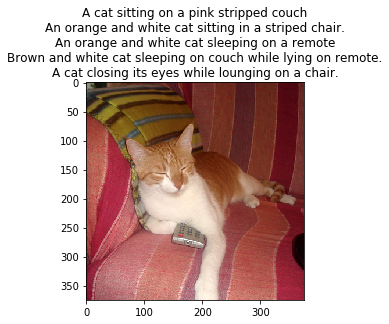

In [28]:
# look at training example (each has 5 captions)
def show_training_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("/home/karen/Downloads/data/train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    # get sample image filenames
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    # zf.read() outputs binary code of images
    # need to decode from bin code to image arrays
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_training_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [29]:
# preview captions data
train_captions[:2], len(train_captions)

([['A long dirt road going through a forest.',
   'A SCENE OF WATER AND A PATH WAY',
   'A sandy path surrounded by trees leads to a beach.',
   'Ocean view through a dirt road surrounded by a forested area. ',
   'dirt path leading beneath barren trees to open plains'],
  ['A group of zebra standing next to each other.',
   'This is an image of of zebras drinking',
   'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
   'Zebras that are bent over and drinking water together.',
   'a number of zebras drinking water near one another']],
 82783)

In [37]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

from collections import Counter

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    sentences = [sentence for cap in train_captions for sentence in cap]
    sentences = split_sentence(' '.join(sentences))
    tokens = Counter(sentences)
    frequent_tokens = [key for key, value in tokens.items() if value>=5]
    vocab = frequent_tokens + [PAD, UNK, START, END]
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    final_result=[]
    img_result=[]
    for caption in captions:
        for sentence in caption:
            result=[vocab[START]]
            for token in split_sentence(sentence):
                if token in vocab: 
                    result+=[vocab[token]]
                else:
                    result+=[vocab[UNK]]
            result+=[vocab[END]]
            img_result.append(result)
            result=[]
        final_result.append(img_result)
        img_result=[]
                
    res = [[[vocab[START]] + [vocab[token] if token in vocab else vocab[UNK] for token in split_sentence(sentence)] + [vocab[END]] for sentence in caption] for caption in captions]
    return res

In [38]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab), vocab['#PAD#'])

8769 1


In [41]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [42]:
len(train_captions_indexed), len(val_captions_indexed)

(82783, 40504)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an euqal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [43]:
train_captions_indexed[0]

[[2, 54, 4462, 2305, 6328, 3354, 7848, 54, 3107, 0],
 [2, 54, 6540, 5127, 8486, 249, 54, 5437, 8507, 0],
 [2, 54, 6502, 5437, 7581, 1124, 8052, 4287, 7905, 54, 639, 0],
 [2, 5120, 8367, 7848, 54, 2305, 6328, 7581, 1124, 54, 3108, 331, 0],
 [2, 2305, 5437, 4286, 710, 587, 8052, 7905, 5174, 5684, 0]]

In [44]:
# get the longest encoded sentence
max(train_captions_indexed[0], key=lambda x:len(x))

[2, 5120, 8367, 7848, 54, 2305, 6328, 7581, 1124, 54, 3108, 331, 0]

In [67]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    matrix=[]
    batch_max = len(max(batch_captions, key=lambda x:len(x)))
    if max_len:
        max_len = min(max_len, batch_max)
    else:
        max_len = batch_max
    for caption in batch_captions:
        cap_len = len(caption)
        if cap_len<=max_len:
            caption+=[pad_idx]*(max_len-cap_len)
        else:
            caption = caption[:max_len]
        matrix.append(caption)
    matrix = np.array(matrix)
    return matrix

In [68]:
batch_captions_to_matrix(train_captions_indexed[1], pad_idx=0)

array([[   2,   54, 3484, 5127, 8755, 7296, 5025, 7905, 2540, 5222,    0],
       [   2, 7835, 3998,  242, 3877, 5127, 5127, 8756, 2468,    0,    0],
       [   2, 8756,  249,  764, 6709, 7804, 6484, 8492, 3738,    0,    0],
       [   2, 8756, 7800,  330,  711, 5254,  249, 2468, 8486, 7919,    0],
       [   2,   54, 5072, 5127, 8756, 2468, 8486, 4975, 5159,  269,    0]])

In [104]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input


In [45]:
train_img_embeds.shape

(82783, 2048)

In [52]:
IMG_EMBED_SIZE = train_img_embeds.shape[1] # 2048
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [53]:
# remember to reset your graph if you want to start building it from scratch!
tf.reset_default_graph()
tf.set_random_seed(42)
s = tf.InteractiveSession()

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [57]:
class decoder:
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE]) # (None, 2048)
    sentences = tf.placeholder('int32', [None, None]) # batch_max_len might be different
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:, :-1]) # exclude the last char of sentence
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(cell=lstm, inputs=word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, shape=[-1, LSTM_UNITS])
    
    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1,])

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [61]:
np.reshape([[1,2,3], [4,5,6]], [-1,])

array([1, 2, 3, 4, 5, 6])

In [58]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [59]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [61]:
train_captions_indexed[0]

[[2, 54, 4462, 2305, 6328, 3354, 7848, 54, 3107, 0],
 [2, 54, 6540, 5127, 8486, 249, 54, 5437, 8507, 0],
 [2, 54, 6502, 5437, 7581, 1124, 8052, 4287, 7905, 54, 639, 0],
 [2, 5120, 8367, 7848, 54, 2305, 6328, 7581, 1124, 54, 3108, 331, 0],
 [2, 2305, 5437, 4286, 710, 587, 8052, 7905, 5174, 5684, 0]]

In [69]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    # here images_embeddings and indexed_captions corresponds row by row
    image_idx = np.random.choice(range(len(images_embeddings)), batch_size, replace=False)
    batch_image_embeddings = images_embeddings[image_idx]
    batch_captions = [cap[np.random.randint(len(cap))] for cap in indexed_captions[image_idx]]
    # need padding to ensure the length of the captioning sentences are the same
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len=max_len)
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [64]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [65]:
# you can load trained weights here
# you can load "weights_{epoch}" and continue training
# uncomment the next line if you need to load weights
saver.restore(s, os.path.abspath("weights"))

INFO:tensorflow:Restoring parameters from /home/karen/workspace/Advanced_ML_HSE/Introduction-To-Deep-Learning/notebooks/week6/weights


In [ ]:
MAX_LEN = 20  # truncate long captions to speed up training
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    train_loss = 0
    pbar = tqdm.tqdm_notebook(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")



Epoch: 0, train loss: 4.310093719482422, val loss: 3.653768141269684

Epoch: 1, train loss: 3.3454977943897246, val loss: 3.1484389114379883

Epoch: 2, train loss: 3.045226105928421, val loss: 2.992725837230682


In [70]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    # vocab_inverse => idx:word
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    print(logits)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

[[ -1.0632595 -10.616826  -10.42775   ...  -5.4132915  -4.970221
   -3.9142747]
 [ -3.4125242 -10.622873  -10.226078  ...  -6.121539   -4.0196548
   -4.258054 ]
 [  1.9395864  -9.076095   -8.886731  ...  -5.375271    0.4434785
   -5.1517363]
 ...
 [  8.847406  -10.174876   -9.661328  ...  -4.5233927  -4.2720203
   -5.4303093]
 [  8.821748  -10.143098   -9.6292715 ...  -4.512379   -4.2465806
   -5.4106746]
 [  8.803145  -10.118174   -9.603903  ...  -4.5036845  -4.2257204
   -5.3926725]]
Loss: 2.4603822
Accuracy: 0.4736129905277402
Example 0
Predicted: a traffic is driving down on a traffic light #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a car is turning left at a street intersection #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a cat sitting sitting on a desk with with a #END# #END# a a laptop bear #END# #END# #END# #END# #END# #END

In [71]:
# save graph weights to file!
saver.save(s, os.path.abspath("weights"))

'/home/karen/workspace/Advanced_ML_HSE/Introduction-To-Deep-Learning/notebooks/week6/weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [72]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights"))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /home/karen/workspace/Advanced_ML_HSE/Introduction-To-Deep-Learning/notebooks/week6/weights


In [73]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [75]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       return list(map(vocab_inverse.get, caption))

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a baseball player swinging a bat at a baseball game


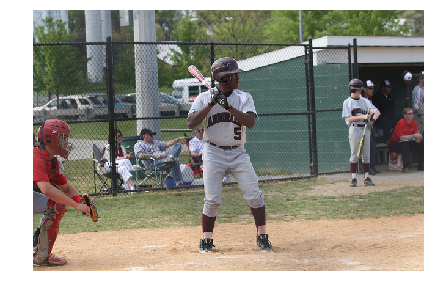

In [77]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("/home/karen/Downloads/data/val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a white plate with a piece of cake and a fork


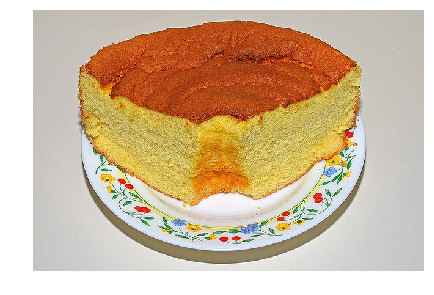

a group of people standing on top of a boat


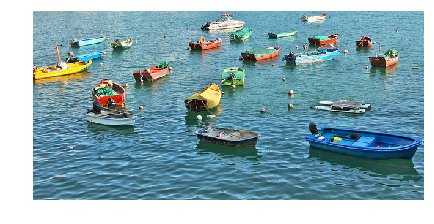

a woman is walking down a street holding a bag of luggage


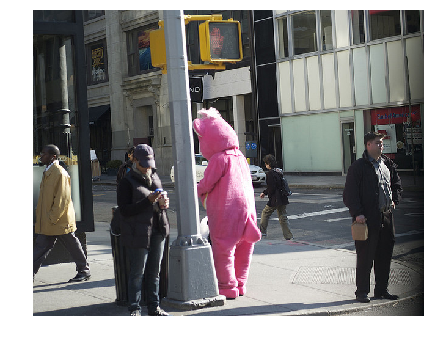

a street sign with a street sign and a street sign


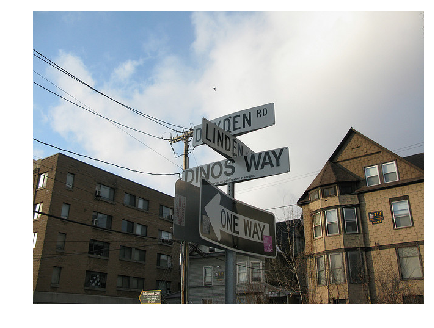

a pair of scissors are on a wall


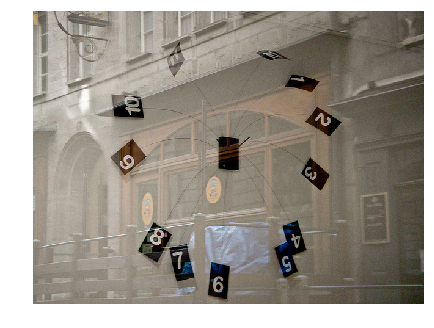

a large jetliner sitting on top of a tarmac


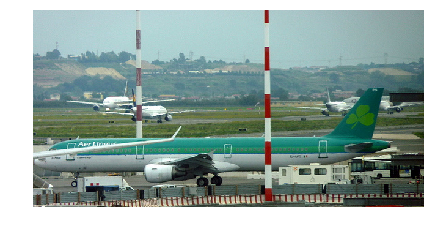

a young boy holding a baby in a bowl


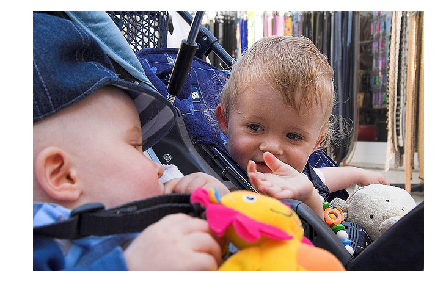

a cat sitting on a chair next to a cat


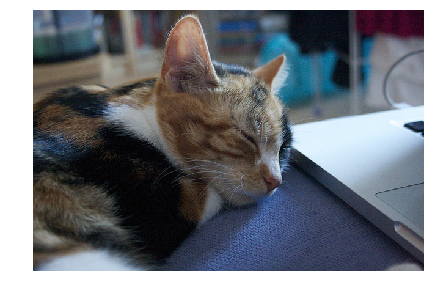

a bathroom with a toilet and a sink


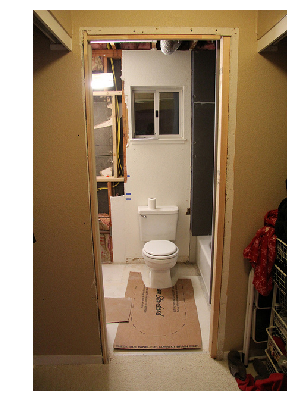

a man on a beach with a surfboard in the water


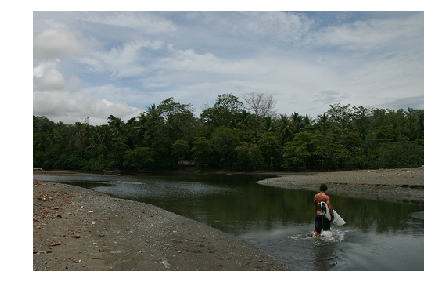

In [78]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("/home/karen/Downloads/data/val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [81]:
import download_utils

In [84]:
download_utils.download_file(
    "https://img.freepik.com/free-photo/positive-businessman-using-laptop_23-2147800028.jpg",
    "man_and_laptop.jpg"
)

In [86]:
download_utils.download_file(url="https://thumbs.dreamstime.com/z/young-man-feeding-dog-sitting-floor-room-est-home-relaxation-concepts-people-pets-relaxed-man-white-dog-puppy-room-123726557.jpg",
                            file_path="man_feeding_dog.jpg")

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a man sitting on a couch with a dog


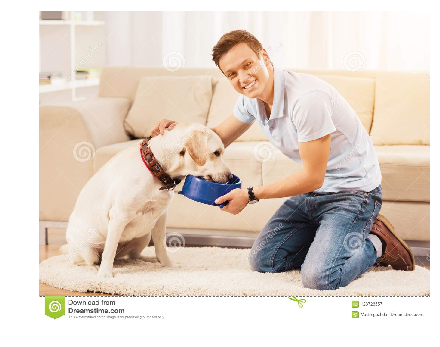

In [88]:
apply_model_to_image_raw_bytes(open("man_feeding_dog.jpg", "rb").read())

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


a man sitting at a table with a laptop computer


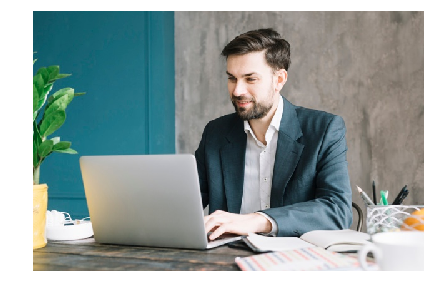

In [89]:
apply_model_to_image_raw_bytes(open("man_and_laptop.jpg", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!